# Plot system_test_fast_results.csv

This notebook loads the results from `system_test_fast_results.csv` and plots the columns by frame index.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
    # Plotting the results


In [65]:
# Read the CSV results
video_name = "FH102_02" #"FH303_01"


df_change = pd.read_csv(
    f"./processed_{video_name}_diff.csv"
)
df_change.index = df_change["center_idx"]
df_change = df_change.drop(columns=["center_idx"])

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(df_change["center_idx"], df_change["std_diff_norm_rgb"], label="Mean RGB Difference")
# plt.title("Mean RGB Difference")
# plt.xlabel("Frame Index")
# plt.ylabel("Mean RGB Difference")
# plt.legend()
# plt.subplot(1, 2, 2)

df_change 


,std_diff_running_mean_20,std_diff_norm_rgb_1
center_idx,,
0,NaN,NaN
1,0.141531,0.271714
2,0.137303,0.301114
3,0.112462,0.307552
4,0.125060,0.332213
...,...,...
21588,NaN,NaN
21589,NaN,NaN
21590,NaN,NaN


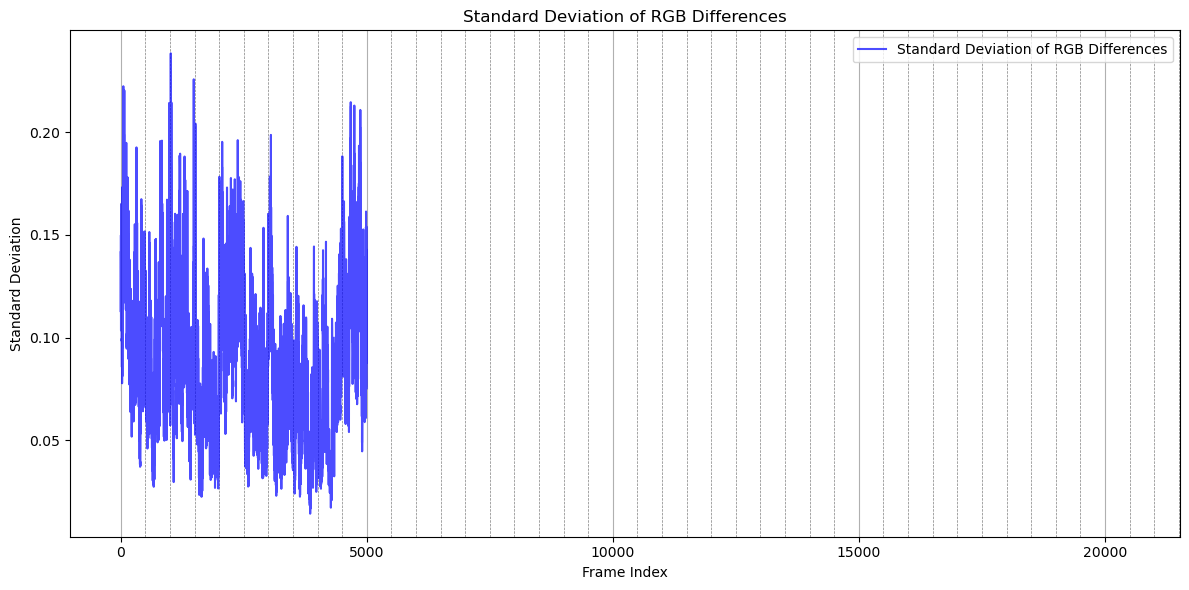

In [67]:

# Plotting the results for all columns in the dataframe starting with "std_diff_" in the same axes
ax = plt.figure(figsize=(12, 6)).add_subplot(111)
# for column in df_change.columns:
#     plt.plot(df_change.index, df_change[column], label=column, alpha=0.7)

plt.plot(df_change.index, df_change["std_diff_running_mean_20"], label="Standard Deviation of RGB Differences", color='blue', alpha=0.7)
for x in range(1, df_change.index.max(), 500):
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5, zorder=0)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', zorder=0)


plt.title("Standard Deviation of RGB Differences")
plt.xlabel("Frame Index")
plt.ylabel("Standard Deviation")
plt.legend()
plt.grid()
plt.tight_layout()


        

## Extract ground truth for video and mark on plots

In [68]:
# Load ground truth CSV and extract FH401_01 rows
gt = pd.read_csv('./data/Weinstein2018MEE_ground_truth.csv')
gt_video = gt[gt['Video'] == video_name]
gt_video = gt_video.set_index('Frame', drop=False)

# deduplicate the index of ground truth
gt_video = gt_video[~gt_video.index.duplicated(keep='first')]
# gt_video[['Frame', 'Truth']]
print(f"number of labels in ground truth: {gt_video.groupby('Truth').size()}")


number of labels in ground truth: Truth
Negative    925
Positive     33
dtype: int64


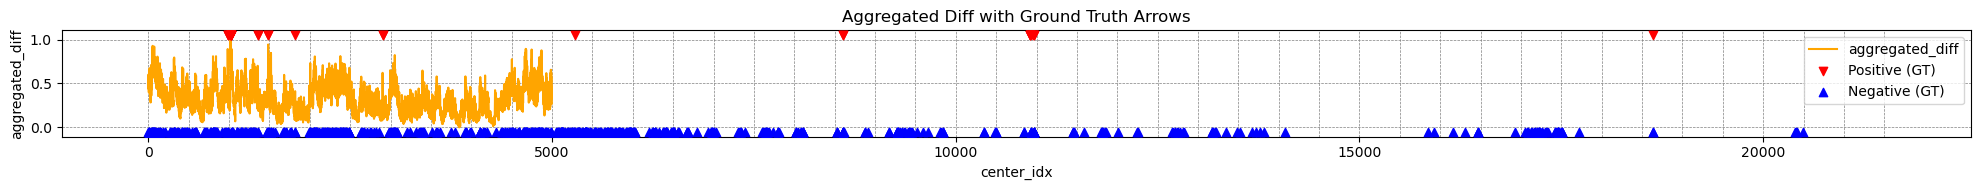

In [70]:
# Plot aggregated_diff with ground truth arrows for FH303_01
df_change['aggregated_diff'] = df_change.filter(like='std_diff_running_mean_20').mean(axis=1)
# 0 - 1 norm
df_change['aggregated_diff'] = (df_change['aggregated_diff'] - df_change['aggregated_diff'].min()) / (df_change['aggregated_diff'].max() - df_change['aggregated_diff'].min())

fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(df_change.index, df_change['aggregated_diff'], label='aggregated_diff', color='orange')

for x in range(1, df_change.index.max(), 500):
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5, zorder=0)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', zorder=0)

# Only plot if ground truth is available
if not gt_video.empty:
    # Arrow up for Positive, arrow down for Negative
    positives = gt_video[gt_video['Truth'].str.lower() == 'positive']
    negatives = gt_video[gt_video['Truth'].str.lower() == 'negative']
    ax.scatter(positives.index, [1.05] * len(positives), marker='v', color='red', label='Positive (GT)', zorder=5)
    ax.scatter(negatives.index, [-0.05] * len(negatives), marker='^', color='blue', label='Negative (GT)', zorder=5)
    
    # Annotate positive markers with frame IDs, spreading out text if labels are close
    # last_frame_id = None
    # c = 0
    # for frame_id in positives.index:
    #     if last_frame_id is not None and abs(frame_id - last_frame_id) < 100:  # Adjust threshold as needed
    #         offset = 1.1 + 0.25 * c  # Add fixed offset of 1 if condition is true
    #         ax.text(frame_id, offset, str(frame_id), color='red', fontsize=8, ha='center')  # Spread out
    #         c += 1
    #     else:
    #         c = 0
    #         ax.text(frame_id, 1.3, str(frame_id), color='red', fontsize=8, ha='center')
    #     last_frame_id = frame_id

ax.set_ylabel('aggregated_diff')
ax.set_xlabel('center_idx')
ax.legend()

plt.title('Aggregated Diff with Ground Truth Arrows')
plt.tight_layout()
plt.show()

In [71]:
top_k = 50  # Specify the number of top frames to retrieve
df_change["aggregated_diff"] = df_change.filter(like='std_diff_').mean(axis=1)
top_k_frames = df_change.nlargest(top_k, 'aggregated_diff')

print(top_k_frames[['aggregated_diff']])


            aggregated_diff
center_idx                 
74                 0.387905
49                 0.383453
54                 0.382875
53                 0.378933
68                 0.377279
56                 0.364894
73                 0.362921
48                 0.362831
62                 0.361783
78                 0.358966
4673               0.358929
4675               0.352606
4674               0.351043
4870               0.348946
50                 0.347251
4680               0.346447
58                 0.345677
84                 0.344556
1018               0.344495
321                0.343527
839                0.342641
4748               0.342001
4864               0.341718
55                 0.340687
1208               0.340489
52                 0.339336
1485               0.339146
2077               0.338595
63                 0.337548
59                 0.336867
2078               0.336759
2063               0.334240
3053               0.330346
832                0

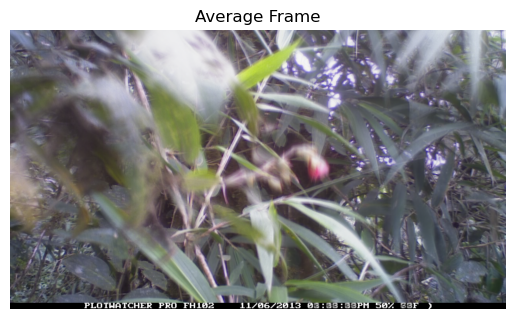

In [72]:
import numpy as np
import random
from torchcodec.decoders import VideoDecoder

video_reader = VideoDecoder(f"./data/{video_name}.avi")

# Set the number of random frames to sample
num_frames = 500

# Generate random frame indices
random_indices = random.sample(range(len(video_reader)), num_frames)

# Initialize an array to accumulate pixel values
average_frame = None

# Iterate through the random frame indices and accumulate pixel values
for idx in random_indices:
    frame = video_reader[idx].permute(1, 2, 0).numpy()  # Convert frame to numpy array (HWC format)
    if average_frame is None:
        average_frame = np.zeros_like(frame, dtype=np.float64)
    average_frame += frame

# Compute the average frame
average_frame /= num_frames

# Convert the average frame back to uint8 for visualization
average_frame = average_frame.astype(np.uint8)

# Display the average frame
plt.imshow(average_frame)
plt.title("Average Frame")
plt.axis("off")
plt.show()


/var/folders/c0/41nq7l9n3131kxqmzmk4h_nh0000gn/T/ipykernel_88788/2727946101.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  frame_rgb = np.abs(frame_rgb - frame_before_rgb)


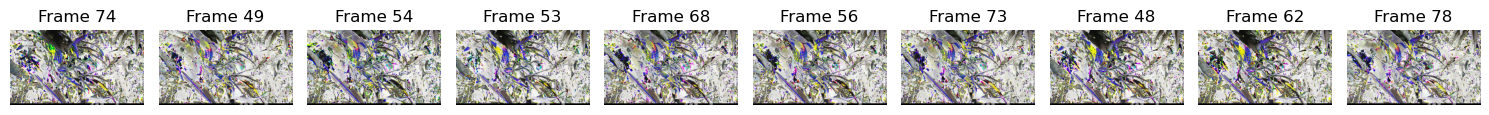

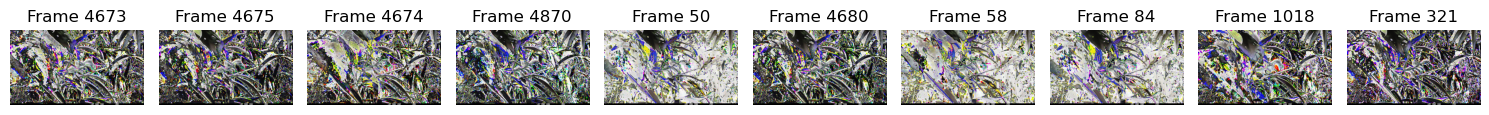

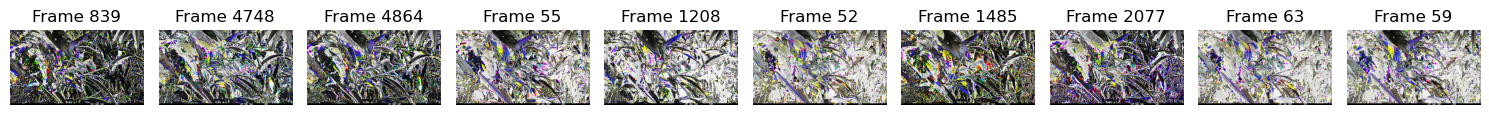

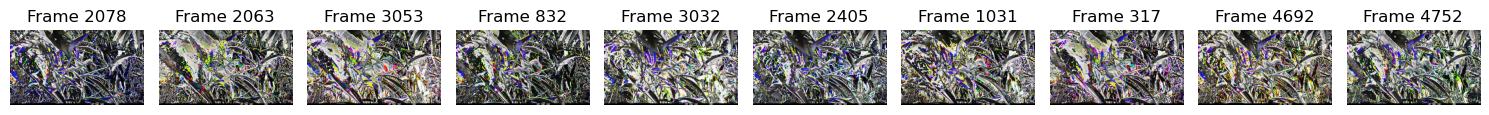

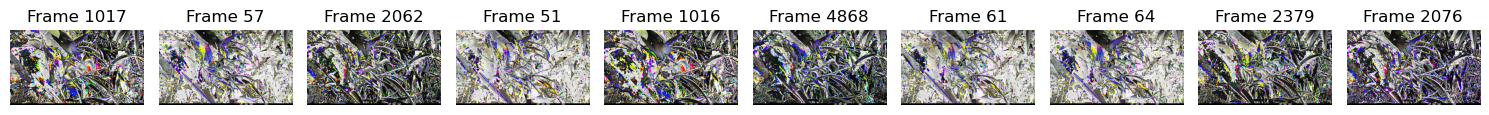

In [73]:
chunk_size = 10  # Number of frames per group
chunks = [top_k_frames.index[i:i + chunk_size] for i in range(0, len(top_k_frames), chunk_size)]

for chunk_idx, chunk in enumerate(chunks):
    fig, axes = plt.subplots(1, len(chunk), figsize=(15, 7))
    for i, frame_idx in enumerate(chunk):

        frame = video_reader[frame_idx]
        frame_before = average_frame # video_reader[frame_idx - 1] if frame_idx > 0 else None

        # Convert the frame from torch tensor to numpy array for plotting
        frame_rgb = frame.permute(1, 2, 0) #.numpy().astype(np.float64)  # Assuming frame is in CHW format
        frame_before_rgb = frame_before #.permute(1, 2, 0).numpy().astype(np.float64)

        # substract the average frame from the current frame
        frame_rgb = np.abs(frame_rgb - frame_before_rgb)
        # Normalize the frame to [0, 1] range for visualization
        frame_rgb = (frame_rgb - frame_rgb.min()) / (frame_rgb.max() - frame_rgb.min())
                
        # back to [0, 255] and convert to uint8
        # frame_rgb = np.clip(frame_rgb, 0, 255).astype(np.uint8)

        # Plot the frame
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f"Frame {frame_idx}")
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Create a DataFrame to store the results
results = []
buff = 10
# Iterate through all top_10_frames
for frame in top_k_frames.index:
    is_within_range = any((positives['Frame'] >= frame - buff) & (positives['Frame'] <= frame + buff))
    results.append({'Frame': frame, 'Within ±5 of Positive GT': is_within_range})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

    Frame  Within ±5 of Positive GT
0   19193                     False
1   17079                      True
2    7844                      True
3     425                     False
4   17078                      True
5    7846                      True
6   19115                     False
7   10402                      True
8   19188                     False
9   19194                     False
10  18791                     False
11  11955                      True
12  10400                      True
13   7845                      True
14  18478                      True
15  17076                      True
16   1959                     False
17  16454                      True
18   1965                     False
19  17077                      True
20  16419                      True
21  19117                     False
22   8460                      True
23  20384                      True
24  16460                      True
25  16416                      True
26  20391                   